# Lab 11. Localization & Detection
by Domrachev Ivan, B20-Ro-01

In [1]:
from keras.datasets import mnist
from nn_from_scratch.optimizers import GradientDescent
from nn_from_scratch.examples.simple_nn import NeuralNetwork
from nn_from_scratch.nodes import ReLU, SoftMaxLoss, Vectorization
from nn_from_scratch.neurons import Linear, Convolution
from nn_from_scratch.interfaces import Neuron
import tensorflow as tf
from tensorflow.keras import layers as t_layers

import d2l
import sys
sys.path.insert(0, '..')
import d2l
import pandas as pd
import os
import json
import numpy as np
from PIL import Image
from bs4 import BeautifulSoup


import numpy as np
from matplotlib import pyplot as plt

2023-11-24 23:35:16.871234: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 23:35:16.931111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 23:35:16.931817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 23:35:17.960984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Part 1. The dataset

To validate the performance, I decided to take [this dataset](https://www.kaggle.com/datasets/mbkinaci/image-localization-dataset/), which is designed for single image localization tasks. I couldn't find any basic dataset for this task.

In [2]:
img = np.array(Image.open('dataset/training_images/mushroom_44.jpg'))
with open('dataset/training_images/mushroom_44.xml', "r") as f:
    data = f.read()
bs = BeautifulSoup(data, 'xml')

In [3]:
bs.find('name').text

'mushroom'

In [4]:
import os


def load_dataset(dirname: str):
    dataset = []
    classes = []
    locations = []
    
    for filepath in os.listdir(dirname):
        if not filepath.endswith('jpg'):
            continue
        fname = filepath.split('.')[0]
        
        dataset.append(np.array(Image.open(f'{dirname}/{filepath}')))
        with open(f'{dirname}/{fname}.xml', "r") as f:
            data = f.read()
        bs = BeautifulSoup(data, 'xml')
        classes.append(bs.find('name').text)
        angles = [int(bs.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]]
        locations.append(
            [angles[0], angles[1], (angles[2]-angles[0]), (angles[3]-angles[1])]
        )
    unique_classes = {elem: idx for idx, elem in enumerate(set(classes))}
    classes_encoded = [unique_classes[cur_class] for cur_class in classes] 
    return np.array(dataset).astype(np.float64), np.array(classes_encoded).astype(np.uint8), np.array(locations).astype(np.uint8)
    
ds, classes, locations = load_dataset('dataset/training_images/')
ds, locations = ds / 255, locations / 255

In [5]:
from matplotlib.patches import Rectangle 
def plot_img(pics, ann, i=0):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(pics[i])
    rect = Rectangle(ann[i][0:2]*255, ann[i][2]*255, ann[i][3]*255, lw=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)

    plt.show()

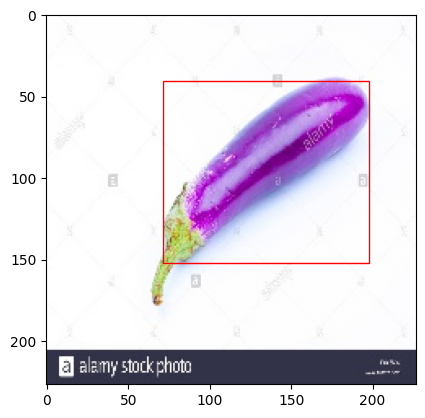

In [6]:
plot_img(ds, locations, i=np.random.randint(len(ds)))

Now, let's shuffle the data:

In [7]:
shuffle = np.random.permutation(len(ds))
ds = ds[shuffle]
classes = classes[shuffle]
locations = locations[shuffle]

In [8]:
N_train = 160
ds_train, ds_val = ds[:N_train], ds[N_train:]
classes_train, classes_val = classes[:N_train], classes[N_train:]
locations_train, locations_val = locations[:N_train], locations[N_train:]

# Part 2. Detection & Localization

In [9]:
batch_size = 10
N, w, h, ch = ds_train.shape
n_output = 4
n_classes = 3
train_pic = ds_train.reshape(N // batch_size, batch_size, ch, w, h)

train_y_ohe = np.zeros((N, n_classes))
train_y_ohe[np.arange(N), classes_train] = 1
train_y_ohe = train_y_ohe.reshape((N // batch_size, batch_size, n_classes))

train_ann = locations_train.reshape(N // batch_size, batch_size, n_output)

In [10]:
from nn_from_scratch.nodes import NormalizedSoftMax
from nn_from_scratch.nodes import ReLU, Vectorization, MSELoss, SoftMax

In [12]:
gds = GradientDescent(lr=1e-2)
layers = [
    Convolution(
        (batch_size, 3, 227, 227), 
        kernel_size=3, 
        output_layers=8,
        use_bias=False,
        W_init_range=1e-3
    ),
    ReLU((batch_size, 8, 225, 225)),
    Convolution(
        (batch_size, 8, 225, 225), 
        kernel_size=6,
        output_layers=2,
        use_bias=False,
        W_init_range=1e-3
    ),
    ReLU((batch_size, 2, 220, 220)),
    Vectorization((batch_size, 2, 220, 220)),
    Linear((batch_size, 2*220*220), (batch_size, n_output), W_init_range=1e-3)
]
loss_fn = MSELoss((batch_size, n_output, ))
network = NeuralNetwork(
    n_input=28, 
    n_output=n_output, 
    batch_size=batch_size, 
    optimizer=gds,
    layers=layers,  
    loss_fn=loss_fn
)
network.fit(train_pic, train_ann, n_epochs=5)

100%|██████████| 16/16 [00:57<00:00,  3.58s/it, loss=1.14]


Epoch 1, Loss: 1.1385340767514291


100%|██████████| 16/16 [00:56<00:00,  3.53s/it, loss=0.399]


Epoch 2, Loss: 0.39913028524093674


100%|██████████| 16/16 [01:02<00:00,  3.91s/it, loss=0.228]


Epoch 3, Loss: 0.2276200560863711


100%|██████████| 16/16 [01:03<00:00,  3.96s/it, loss=0.194]


Epoch 4, Loss: 0.19387659254138412


100%|██████████| 16/16 [00:57<00:00,  3.59s/it, loss=0.187]

Epoch 5, Loss: 0.1871112640946427


array([0.18711126])

In [13]:
val_pic = ds_val[:batch_size]
val_ann = locations_val[:batch_size]

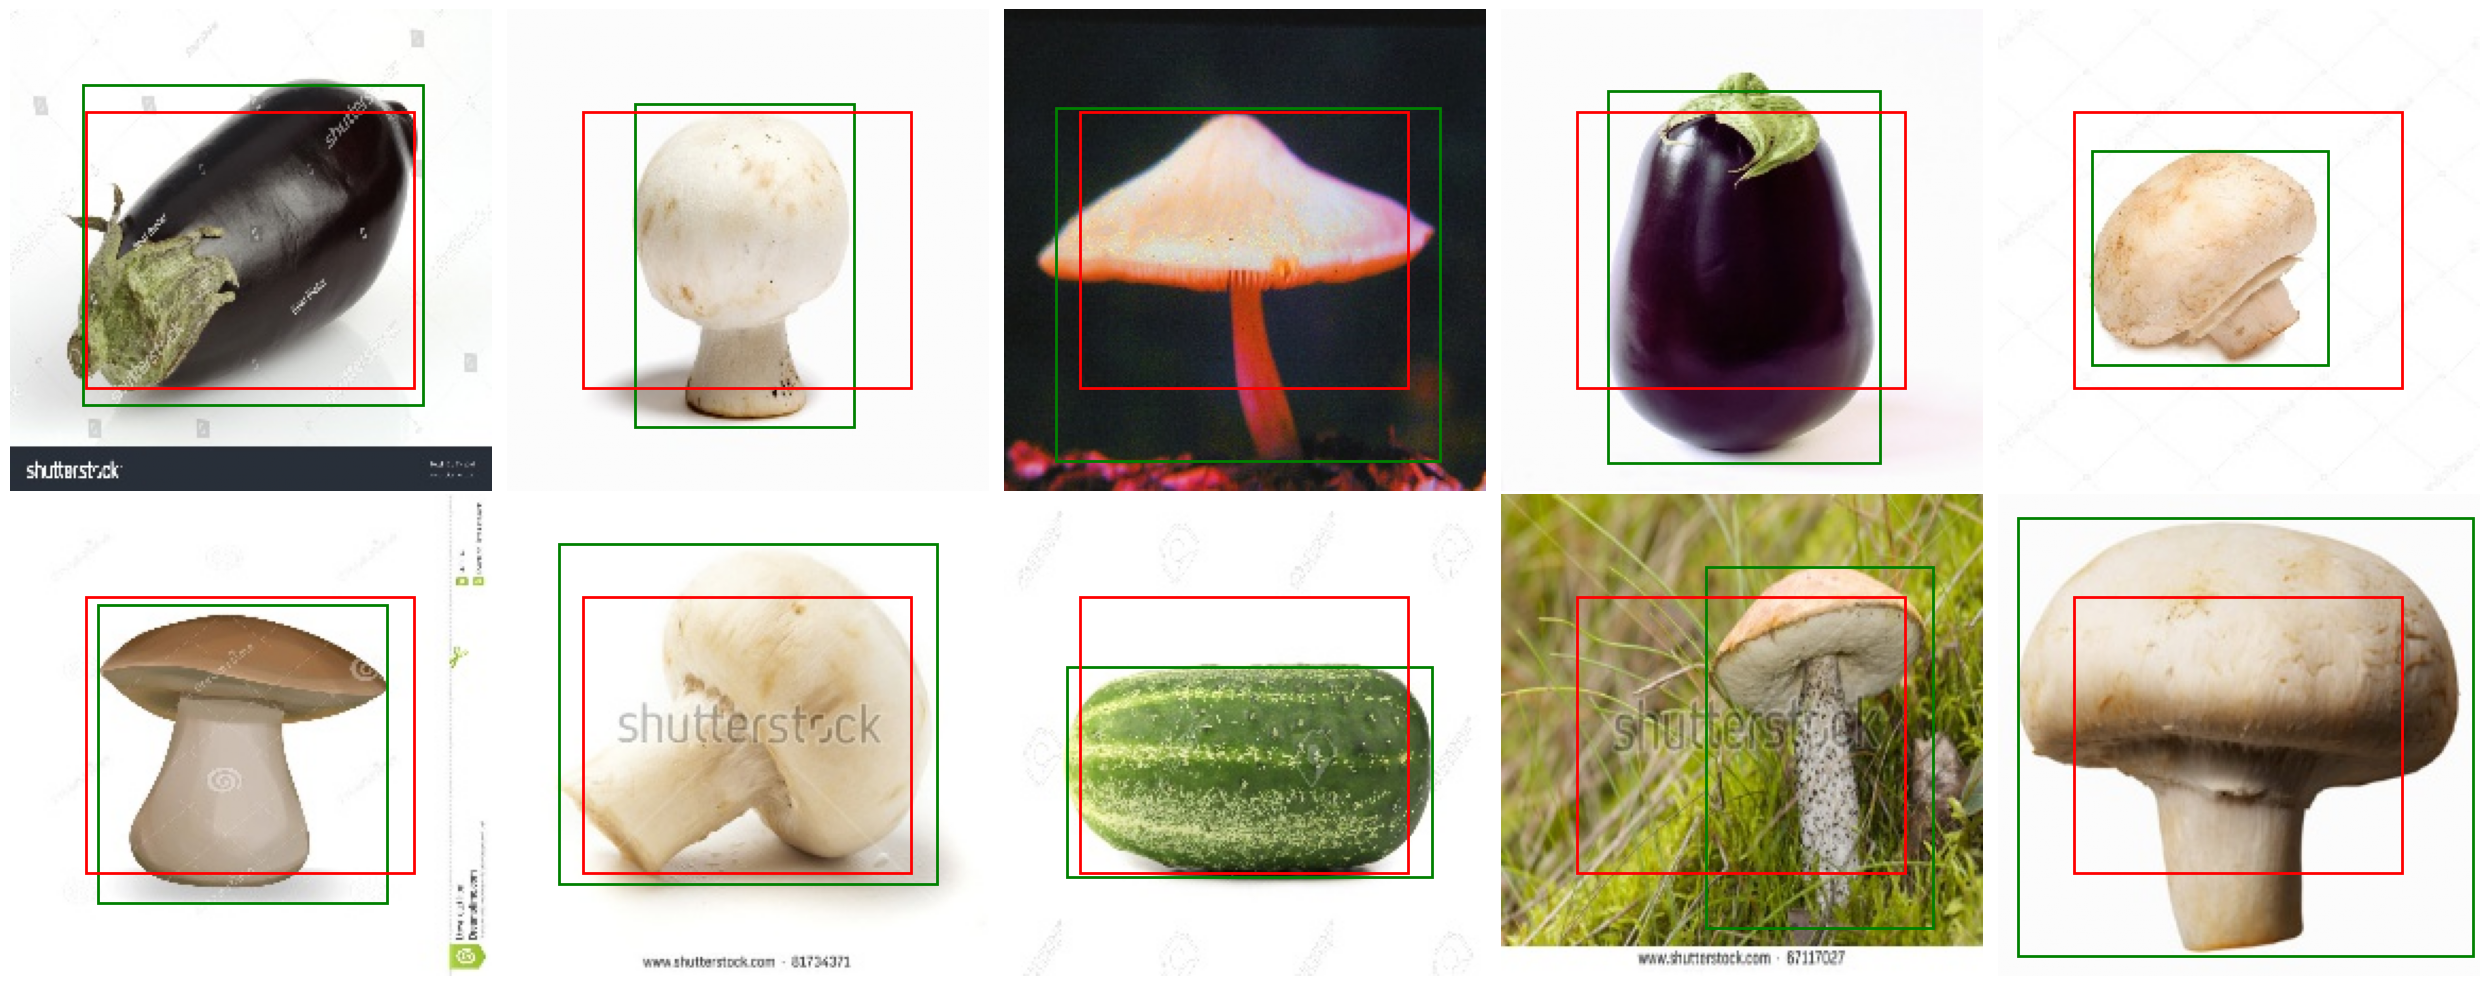

In [14]:
pic_preds = network.predict(val_pic.reshape(batch_size, ch, w, h))

fig, axs = plt.subplots(2, 5, figsize=(5*5, 2*5))
axs = axs.ravel()

for i in range(len(pic_preds)):
    axs[i].imshow(val_pic[i])
    rect = Rectangle((val_ann[i][0:2])*255, (val_ann[i][2])*255, (val_ann[i][3])*255, lw=2, edgecolor='g',facecolor='none')
    rect_pred = Rectangle((pic_preds[i][0:2])*255, (pic_preds[i][2])*255, (pic_preds[i][3])*255, lw=2, edgecolor='r',facecolor='none')
    axs[i].add_patch(rect)
    axs[i].add_patch(rect_pred)
    axs[i].set_axis_off()

plt.tight_layout()
plt.show()

In [15]:
train_pic.shape

(16, 10, 3, 227, 227)

In [25]:
gds = GradientDescent(lr=1e-1)
layers = [
    Convolution(
        (batch_size, 3, 227, 227), 
        kernel_size=3, 
        output_layers=8,
        use_bias=False,
        W_init_range=1.0
    ),
    ReLU((batch_size, 8, 225, 225)),
    Convolution(
        (batch_size, 8, 225, 225), 
        kernel_size=6,
        output_layers=2,
        use_bias=False,
        W_init_range=1.0
    ),
    ReLU((batch_size, 2, 220, 220)),
    Vectorization((batch_size, 2, 220, 220)),
    Linear((batch_size, 2*220*220), (batch_size, n_classes), W_init_range=1.0)
]
loss_fn = SoftMaxLoss((batch_size, n_output, ))
network = NeuralNetwork(
    n_input=28, 
    n_output=n_output, 
    batch_size=batch_size, 
    optimizer=gds,
    layers=layers,  
    loss_fn=loss_fn
)
network.fit(train_pic, train_y_ohe, n_epochs=5)

100%|██████████| 16/16 [01:02<00:00,  3.88s/it, loss=1.45]


Epoch 1, Loss: 1.44755806774559


100%|██████████| 16/16 [01:01<00:00,  3.86s/it, loss=1.39]


Epoch 2, Loss: 1.3859439492398558


100%|██████████| 16/16 [01:02<00:00,  3.94s/it, loss=1.35]


Epoch 3, Loss: 1.3452448193162097


100%|██████████| 16/16 [01:00<00:00,  3.81s/it, loss=1.32]


Epoch 4, Loss: 1.3217596195706163


100%|██████████| 16/16 [01:02<00:00,  3.88s/it, loss=1.31]

Epoch 5, Loss: 1.3057963670669368


array([1.30579637])

In [26]:
def compute_accuracy(test_X: np.array, test_y: np.array, model) -> float:
    correct_predictions = 0
    total = 0

    for test_inputs, test_labels in zip(test_X, test_y):
        predicts = model.predict(test_inputs)
        pred_class = np.argmax(predicts, axis=1)
        
        correct_predictions += (pred_class == test_labels).sum()
        total += len(test_labels)

    return correct_predictions / total

In [27]:
val_pic = ds_val[:batch_size].reshape(1, batch_size, ch, w, h)

val_y = classes_val[:batch_size].reshape(1, batch_size)

acc = compute_accuracy(val_pic, val_y, network)
print(f"Accuracy: {acc}")

Accuracy: 0.3
